## Import libs

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import psycopg2
from dotenv import load_dotenv
import os
from sqlalchemy import create_engine, text

## Funções

In [2]:
# Testar a conexão ao banco de dados
def test_connection(engine):

    try:
        with engine.connect() as connection:
            
            # Testar a versão do PostgreSQL
            result = connection.execute(text("SELECT version();"))
            versao = result.fetchone()
            print("✅ Conectado com sucesso:", versao[0])

            # Listar as tabelas no schema público
            result = connection.execute(text("""
                SELECT table_name
                FROM information_schema.tables
                WHERE table_schema = 'public';
            """))
            tabelas = result.fetchall()
            print("📄 Tabelas no banco:")
            for tabela in tabelas:
                print("-", tabela[0])

    except Exception as e:
        print("❌ Erro ao executar comandos:", e)
        sys.exit()

In [3]:

# criando um função de costumização para usar nos graficos verticais
def grafico_vertical(ax,valor,titulo):
    # Removendo a caixa ao redor do gráfico
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    # Ajustando a altura do eixo y
    ax.set_ylim(0, valor.max() * 1.1)  # aumenta o limite superior e inferior em 10%
    #removendo o tick do eixo x
    ax.xaxis.set_ticks_position('none')
    # Removendo o label do eixo y
    ax.set_ylabel('',fontsize=10)
    # Removendo o label do eixo x
    ax.set_xlabel('',fontsize=10)
    # Removendo os valores do eixo y
    ax.yaxis.set_ticks([])  # Remove as marcações do eixo y
    ax.yaxis.set_ticklabels([])  # Remove os rótulos do eixo y
    # Ajustando o tamanho das fontes dos ticks
    ax.tick_params(axis='both', which='major', labelsize=10)
    # Definindo o título do gráfico em negrito e tamanho 12
    ax.set_title(titulo, fontweight='bold', fontsize=12)
    # ajustando as porporções
    plt.tight_layout()

In [4]:

# criando um função de costumização para usar nos graficos horizontais
def grafico_horizontal(ax,valor,titulo):
    # Removendo a caixa ao redor do gráfico
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    # Ajustando a altura do eixo y
    ax.set_xlim(0, valor.max() * 1.1)  # aumenta o limite superior em 10%
    #removendo o tick do eixo y
    ax.yaxis.set_ticks_position('none')
    # Removendo o label do eixo y
    ax.set_ylabel('',fontsize=10)
    # Removendo o label do eixo x
    ax.set_xlabel('',fontsize=10)
    # Removendo os valores do eixo y
    ax.xaxis.set_ticks([])  # Remove as marcações do eixo x
    ax.xaxis.set_ticklabels([])  # Remove os rótulos do eixo x
    # Ajustando o tamanho das fontes dos ticks
    ax.tick_params(axis='both', which='major', labelsize=10)
    # Definindo o título do gráfico em negrito e tamanho 12
    ax.set_title(titulo, fontweight='bold', fontsize=12)
    # ajustando as porporções
    plt.tight_layout()

## Conexão Postgresql

In [5]:
# Carregar as credencias do .env
load_dotenv()


# PostgreSQL
usuario_pg = os.getenv("POSTGRES_USER_PNAD")
senha_pg = os.getenv("POSTGRES_PASSWORD_PNAD")
host_pg = os.getenv("POSTGRES_HOST_PNAD")
porta_pg = os.getenv("POSTGRES_PORT_PNAD")
banco_pg = os.getenv("POSTGRES_DB_PNAD")


In [6]:
# Criar engine com banco 
engine = create_engine(f"postgresql+psycopg2://{usuario_pg}:{senha_pg}@{host_pg}:{porta_pg}/{banco_pg}")

# Testar a conexão
test_connection(engine)

✅ Conectado com sucesso: PostgreSQL 17.4 on x86_64-pc-linux-gnu, compiled by gcc (GCC) 12.4.0, 64-bit
📄 Tabelas no banco:
- questionario_covid
- codigo_uf
- pnad_covid


## Análises

### Análise exploratória

In [7]:
# Executando a query e carregando os dados diretamente em um DataFrame
query = "SELECT * FROM questionario_covid;"
df = pd.read_sql_query(query, con=engine)

In [8]:
# Ajusta coluna de modaria
df.rename(columns={'a006': 'situacao_escolar', 'modaria':'moradia'}, inplace=True)

df['situacao_escolar'] = df['situacao_escolar'].apply(lambda x: 'Sim' if x == 1 else 'Não' if x == 2 else 'Desconhecido')


In [9]:

# Ajusta respostas de modaria
mapeamento_moradia = {1: 'Própria', 2: 'Própria', 3: 'Aluguel', 4: 'Cedido', 5: 'Cedido', 6: 'Cedido'}
df['moradia'] = df['moradia'].map(mapeamento_moradia).fillna('Desconhecido')


In [22]:

# coluna para identificar se teve ao menos 1 sintoma
colunas = [
    'frebre_semana_anterior',
    'tosse_semana_anterior',
    'dificuldade_de_respirar_semana_anterior',
    'perda_olfato_paladar_semana_anterior'
]

# Criar a coluna: 1 se ao menos uma coluna tiver 'sim', 0 caso contrário
df['sintoma_semana_anterior'] = df[colunas].apply(lambda x: 1 if 'Sim' in x.values else 0, axis=1)

In [23]:
# Filtrando apenas quem teve sintoma
df_filtrado = df[df['sintoma_semana_anterior'] == 1]

In [24]:

print("Visualizar as primeiras 5 linhas do DataFrame")
print(df_filtrado.head())

Visualizar as primeiras 5 linhas do DataFrame
      ano  mes_pesquisa  semana_mes  uf  capital  rm_ride    estado sigla  \
26   2020             9           3  11     11.0     -1.0  Rondônia    RO   
34   2020             9           1  11     11.0     -1.0  Rondônia    RO   
35   2020             9           1  11     11.0     -1.0  Rondônia    RO   
63   2020             9           3  11     11.0     -1.0  Rondônia    RO   
116  2020             9           3  12     12.0     -1.0      Acre    AC   

    regiao  idade  ... doenca_respiratoria doencas_cardiacas depressao cancer  \
26   Norte      8  ...                 Não               Não       Não    Não   
34   Norte     25  ...                 Não               Não       Não    Não   
35   Norte     21  ...                 Não               Não       Não    Não   
63   Norte     31  ...                 Não               Não       Não    Não   
116  Norte     55  ...                 Não               Não       Não    Não   

    

In [25]:

print("\nObter informações sobre as colunas, tipos de dados e valores nulos")
df_filtrado.info()


Obter informações sobre as colunas, tipos de dados e valores nulos
<class 'pandas.core.frame.DataFrame'>
Index: 22243 entries, 26 to 1149073
Data columns (total 47 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   ano                                      22243 non-null  int64  
 1   mes_pesquisa                             22243 non-null  int64  
 2   semana_mes                               22243 non-null  int64  
 3   uf                                       22243 non-null  int64  
 4   capital                                  22243 non-null  float64
 5   rm_ride                                  22243 non-null  float64
 6   estado                                   22243 non-null  object 
 7   sigla                                    22243 non-null  object 
 8   regiao                                   22243 non-null  object 
 9   idade                                    22243 non

In [26]:

print("Informações sobre o DataFrame:")
df_filtrado.shape

Informações sobre o DataFrame:


(22243, 47)

In [27]:

print("Gerar estatísticas descritivas para colunas numéricas")
df_filtrado.describe().T


Gerar estatísticas descritivas para colunas numéricas


,count,mean,std,min,25%,50%,75%,max
ano,22243.0,2020.000000,0.000000,2020.0,2020.0,2020.0,2020.0,2020.0
mes_pesquisa,22243.0,9.974644,0.836238,9.0,9.0,10.0,11.0,11.0
semana_mes,22243.0,2.513870,1.111136,1.0,2.0,3.0,4.0,4.0
uf,22243.0,31.584993,11.367274,11.0,23.0,31.0,41.0,53.0
capital,22243.0,7.894619,15.950455,-1.0,-1.0,-1.0,13.0,53.0
rm_ride,22243.0,10.482804,16.635592,-1.0,-1.0,-1.0,26.0,52.0
idade,22243.0,38.999775,21.833915,0.0,22.0,38.0,55.0,111.0
sintoma_semana_anterior,22243.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0


In [28]:
print(df_filtrado.columns)

Index(['ano', 'mes_pesquisa', 'semana_mes', 'uf', 'capital', 'rm_ride',
       'estado', 'sigla', 'regiao', 'idade', 'sexo', 'cor', 'escolaridade',
       'situacao_escolar', 'buscou_auxilio_medico', 'precisou_de_internacao',
       'precisou_de_sedacao', 'plano_de_saude', 'realizou_teste_covid',
       'resultado_teste_swab', 'resultado_teste_dedo', 'resultado_teste_veia',
       'frebre_semana_anterior', 'tosse_semana_anterior',
       'dor_de_garganta_semana_anterior',
       'dificuldade_de_respirar_semana_anterior',
       'dor_de_cabeca_semana_anterior', 'dor_no_peito_semana_anterior',
       'nausea_semana_anterior', 'nariz_constipado_semana_anterior',
       'fadiga_semana_anterior', 'dor_nos_olhos_semana_anterior',
       'perda_olfato_paladar_semana_anterior', 'dor_muscular_semana_anterior',
       'diarreia_semana_anterior', 'diabetes', 'hipertensao',
       'doenca_respiratoria', 'doencas_cardiacas', 'depressao', 'cancer',
       'trabalha_atualmente', 'moradia', 'isolament

### Caracterização dos sintomas clínicos da população

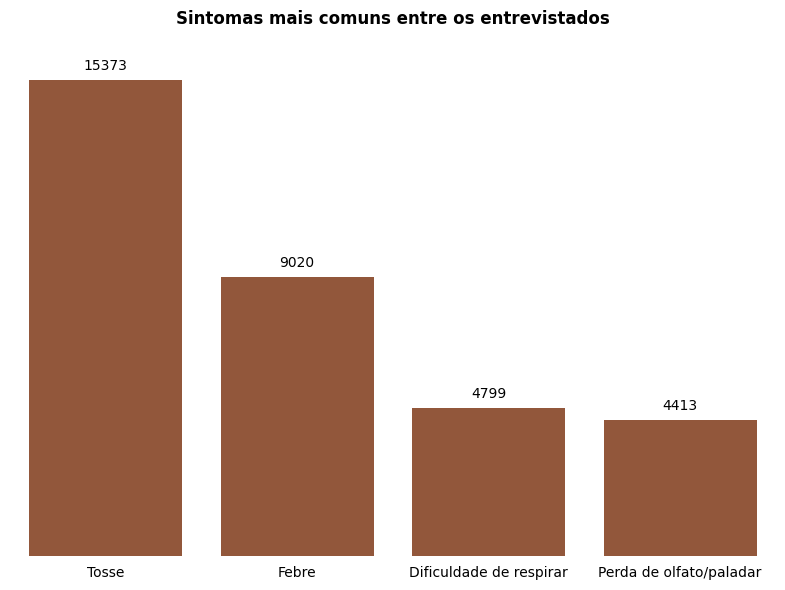

In [ ]:
colunas = [
    'frebre_semana_anterior',
    'tosse_semana_anterior',
    'dificuldade_de_respirar_semana_anterior',
    'perda_olfato_paladar_semana_anterior'
]

# Map para nomes curtos
nomes_sintomas = {
    'frebre_semana_anterior': 'Febre',
    'tosse_semana_anterior': 'Tosse',
    'dificuldade_de_respirar_semana_anterior': 'Dificuldade de respirar',
    'perda_olfato_paladar_semana_anterior': 'Perda de olfato/paladar'
}

contagem_sintomas = df[colunas].apply(lambda x: (x=='Sim').sum())
contagem_sintomas.index = [nomes_sintomas[col] for col in colunas]

# ordenando os valores em ordem decrescente
contagem_sintomas.sort_values(ascending=False,inplace = True)

# definindo o tamanho da figura
plt.figure(figsize=(8,6))
# criando o grafico de quantauxilio_emergencial de vinhos produzida
ax = sns.barplot(x = contagem_sintomas.index,y = contagem_sintomas.values, color = 'sienna')

# criando rotulo de dados no grafico 
for p in ax.patches:
    ax.annotate(f'{p.get_height():.0f}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10),
                textcoords='offset points')

# adicionando o titulo no grafico 
grafico_vertical(ax,contagem_sintomas,'Sintomas mais comuns entre os entrevistados')

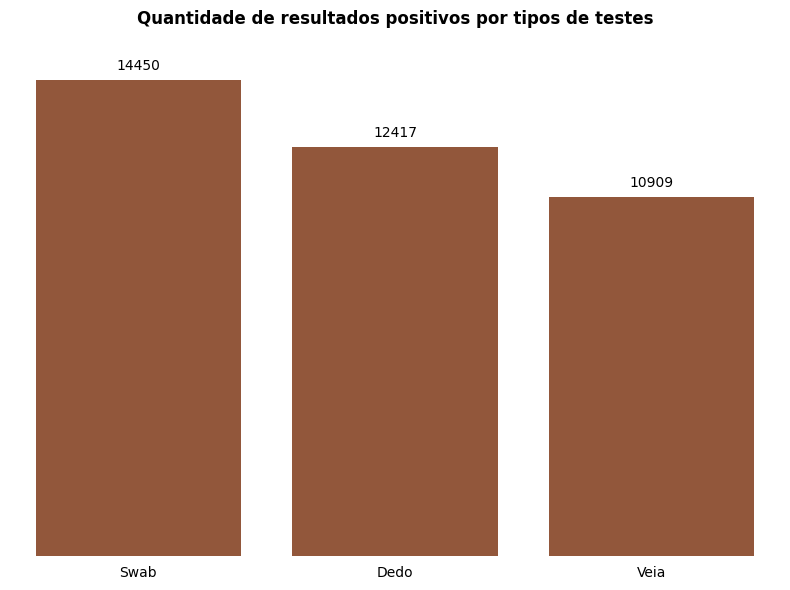

In [46]:
colunas_testes = [
    'resultado_teste_swab',
    'resultado_teste_dedo',
    'resultado_teste_veia'
]

# Map para nomes curtos
nomes_testes = {
    'resultado_teste_swab': 'Swab',
    'resultado_teste_dedo': 'Dedo',
    'resultado_teste_veia': 'Veia'
}

contagem_testes = df[colunas_testes].apply(lambda x: (x=='Positivo').sum())
contagem_testes.index = [nomes_testes[col] for col in colunas_testes]

# ordenando os valores em ordem decrescente
contagem_testes.sort_values(ascending=False,inplace = True)

# definindo o tamanho da figura
plt.figure(figsize=(8,6))
# criando o grafico de quantauxilio_emergencial de vinhos produzida
ax = sns.barplot(x = contagem_testes.index,y = contagem_testes.values, color = 'sienna')

# criando rotulo de dados no grafico 
for p in ax.patches:
    ax.annotate(f'{p.get_height():.0f}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10),
                textcoords='offset points')

# adicionando o titulo no grafico 
grafico_vertical(ax,contagem_testes,'Quantidade de resultados positivos por tipos de testes')

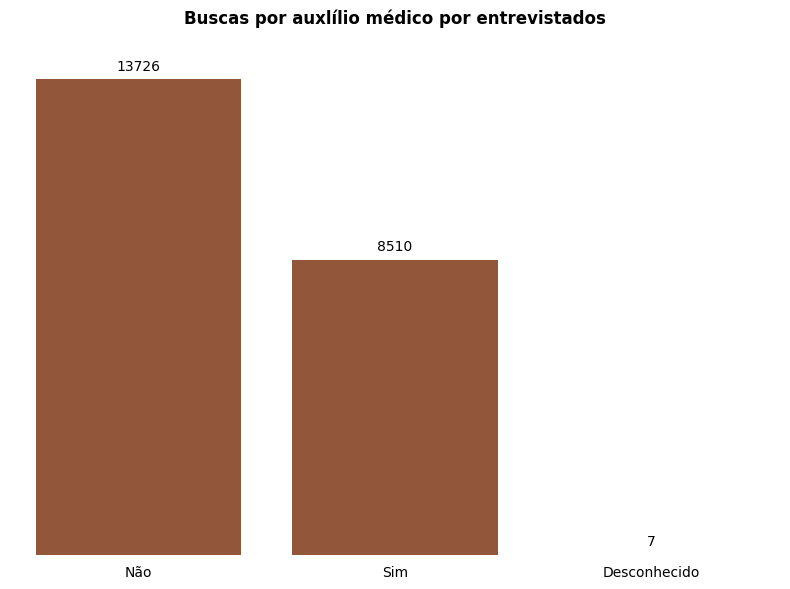

In [48]:
# Distribuição por buscou_auxilio_medico
buscou_auxilio_medico = df_filtrado['buscou_auxilio_medico'].value_counts()
# ordenando os valores em ordem decrescente
buscou_auxilio_medico.sort_values(ascending=False,inplace = True)

# definindo o tamanho da figura
plt.figure(figsize=(8,6))
# criando o grafico de quantbuscou_auxilio_medico de vinhos produzida
ax = sns.barplot(x = buscou_auxilio_medico.index,y = buscou_auxilio_medico.values, color = 'sienna')

# criando rotulo de dados no grafico 
for p in ax.patches:
    ax.annotate(f'{p.get_height():.0f}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10),
                textcoords='offset points')

# adicionando o titulo no grafico 
grafico_vertical(ax,buscou_auxilio_medico,'Buscas por auxlílio médico por entrevistados')

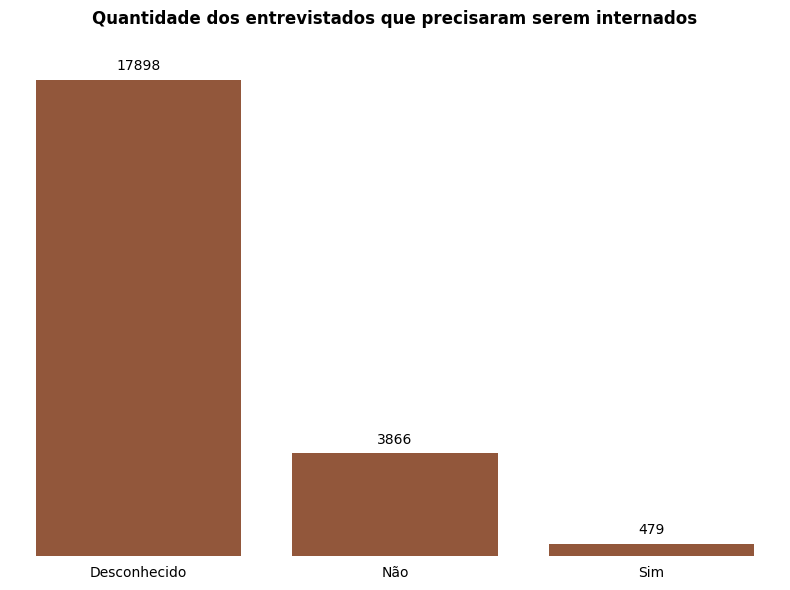

In [50]:
# Distribuição por precisou_de_internacao
precisou_de_internacao = df_filtrado['precisou_de_internacao'].value_counts()
# ordenando os valores em ordem decrescente
precisou_de_internacao.sort_values(ascending=False,inplace = True)

# definindo o tamanho da figura
plt.figure(figsize=(8,6))
# criando o grafico de quantprecisou_de_internacao de vinhos produzida
ax = sns.barplot(x = precisou_de_internacao.index,y = precisou_de_internacao.values, color = 'sienna')

# criando rotulo de dados no grafico 
for p in ax.patches:
    ax.annotate(f'{p.get_height():.0f}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10),
                textcoords='offset points')

# adicionando o titulo no grafico 
grafico_vertical(ax,precisou_de_internacao,'Quantidade dos entrevistados que precisaram serem internados')

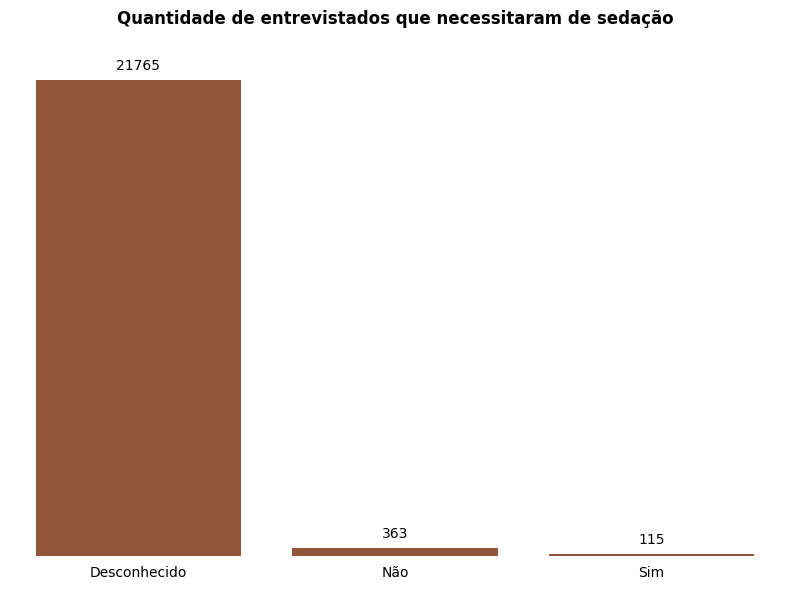

In [49]:
# Distribuição por precisou_de_sedacao
precisou_de_sedacao = df_filtrado['precisou_de_sedacao'].value_counts()
# ordenando os valores em ordem decrescente
precisou_de_sedacao.sort_values(ascending=False,inplace = True)

# definindo o tamanho da figura
plt.figure(figsize=(8,6))
# criando o grafico de quantprecisou_de_sedacao de vinhos produzida
ax = sns.barplot(x = precisou_de_sedacao.index,y = precisou_de_sedacao.values, color = 'sienna')

# criando rotulo de dados no grafico 
for p in ax.patches:
    ax.annotate(f'{p.get_height():.0f}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10),
                textcoords='offset points')

# adicionando o titulo no grafico 
grafico_vertical(ax,precisou_de_sedacao,'Quantidade de entrevistados que necessitaram de sedação')

### Comportamento da população na época da COVID-19

/var/folders/rf/8wnxmp196n904zdcm654qfbc0000gn/T/ipykernel_8082/1976440000.py:24: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


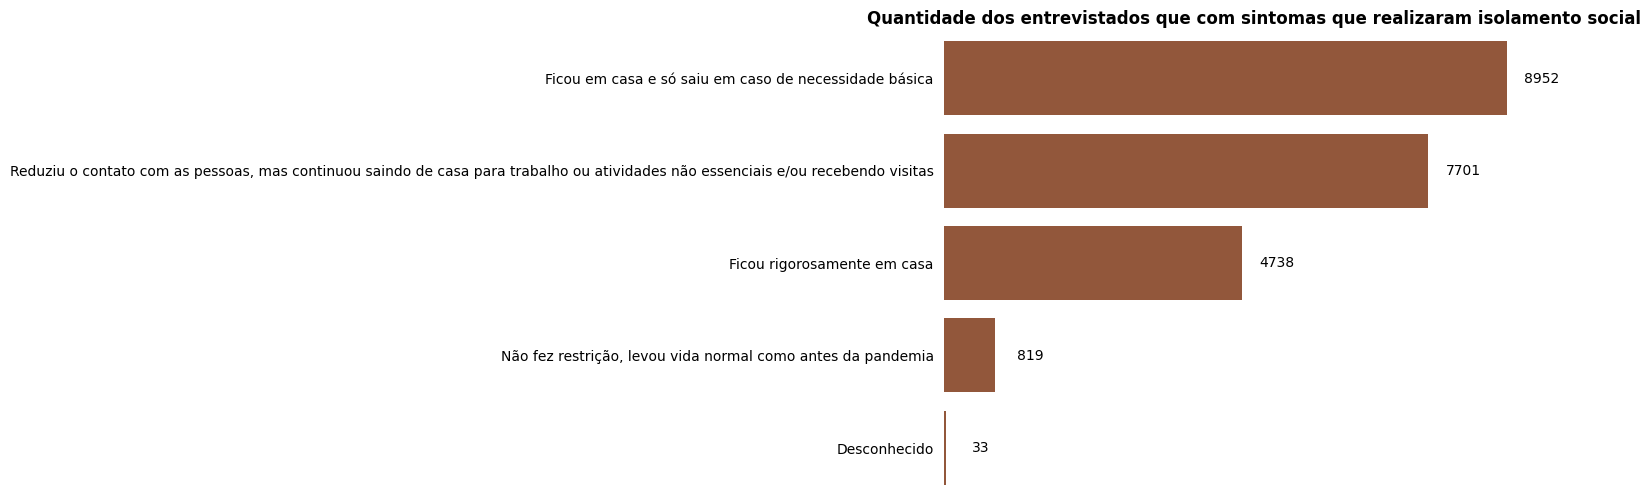

In [34]:
# Distribuição por isolamento_social
isolamento_social = df_filtrado['isolamento_social'].value_counts()
# ordenando os valores em ordem decrescente
isolamento_social.sort_values(ascending=False,inplace = True)

# definindo o tamanho da figura
plt.figure(figsize=(8,6))
# criando o grafico de isolamento_social
ax = sns.barplot(x = isolamento_social.values,y = isolamento_social.index, color = 'sienna')

# criando rotulo de dados no grafico 
for p in ax.patches:
    width = p.get_width()
    ax.annotate(f'{width:.0f}',
                 (p.get_x() + width, p.get_y() + p.get_height() / 2),
                 ha='center', va='center', xytext=(25, 0),
                 textcoords='offset points')

# adicionando o titulo no grafico 
grafico_horizontal(ax,isolamento_social,'Quantidade dos entrevistados que com sintomas que realizaram isolamento social')

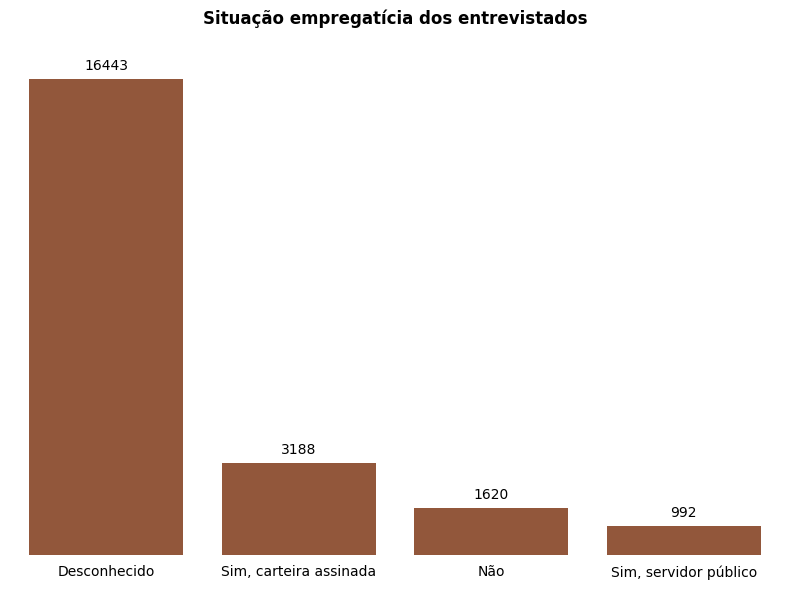

In [36]:
# Distribuição por trabalha_atualmente
trabalha_atualmente = df_filtrado['trabalha_atualmente'].value_counts()
# ordenando os valores em ordem decrescente
trabalha_atualmente.sort_values(ascending=False,inplace = True)

# definindo o tamanho da figura
plt.figure(figsize=(8,6))
# criando o grafico de quantidade de trabalha atualmente
ax = sns.barplot(x = trabalha_atualmente.index,y = trabalha_atualmente.values, color = 'sienna')

# criando rotulo de dados no grafico 
for p in ax.patches:
    ax.annotate(f'{p.get_height():.0f}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10),
                textcoords='offset points')

# adicionando o titulo no grafico 
grafico_vertical(ax,trabalha_atualmente,'Situação empregatícia dos entrevistados')

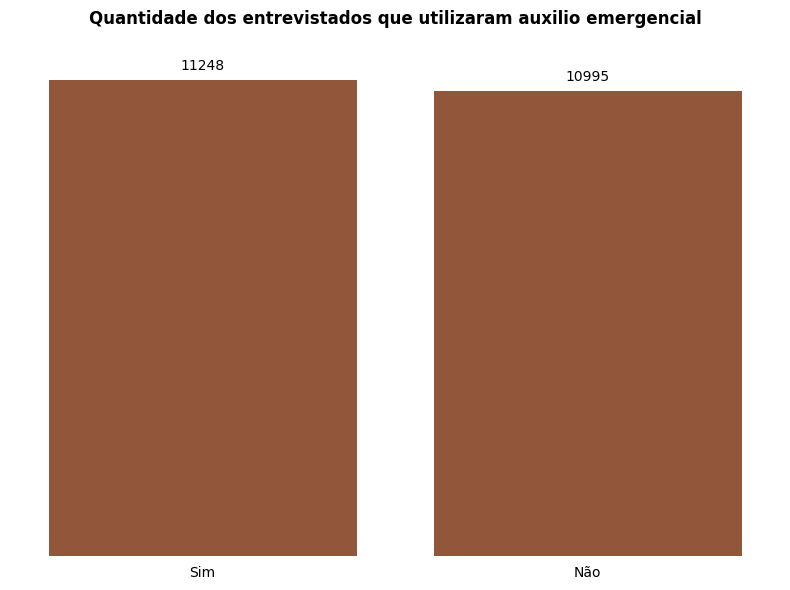

In [35]:
# Distribuição por auxilio_emergencial
auxilio_emergencial = df_filtrado['auxilio_emergencial'].value_counts()
# ordenando os valores em ordem decrescente
auxilio_emergencial.sort_values(ascending=False,inplace = True)

# definindo o tamanho da figura
plt.figure(figsize=(8,6))
# criando o grafico de quantauxilio_emergencial de vinhos produzida
ax = sns.barplot(x = auxilio_emergencial.index,y = auxilio_emergencial.values, color = 'sienna')

# criando rotulo de dados no grafico 
for p in ax.patches:
    ax.annotate(f'{p.get_height():.0f}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10),
                textcoords='offset points')

# adicionando o titulo no grafico 
grafico_vertical(ax,auxilio_emergencial,'Quantidade dos entrevistados que utilizaram auxilio emergencial')

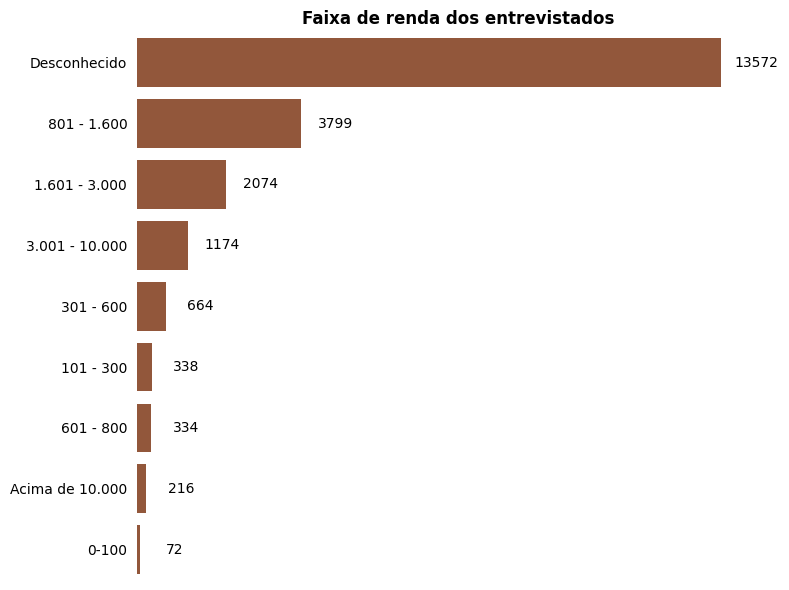

In [37]:


# Distribuição por faixa_salarial
faixa_salarial = df_filtrado['faixa_salarial'].value_counts()
# ordenando os valores em ordem decrescente
faixa_salarial.sort_values(ascending=False,inplace = True)

# definindo o tamanho da figura
plt.figure(figsize=(8,6))
# criando o grafico de faixa_salarial
ax = sns.barplot(x = faixa_salarial.values,y = faixa_salarial.index, color = 'sienna')

# criando rotulo de dados no grafico 
for p in ax.patches:
    width = p.get_width()
    ax.annotate(f'{width:.0f}',
                 (p.get_x() + width, p.get_y() + p.get_height() / 2),
                 ha='center', va='center', xytext=(25, 0),
                 textcoords='offset points')

# adicionando o titulo no grafico 
grafico_horizontal(ax,faixa_salarial,'Faixa de renda dos entrevistados')

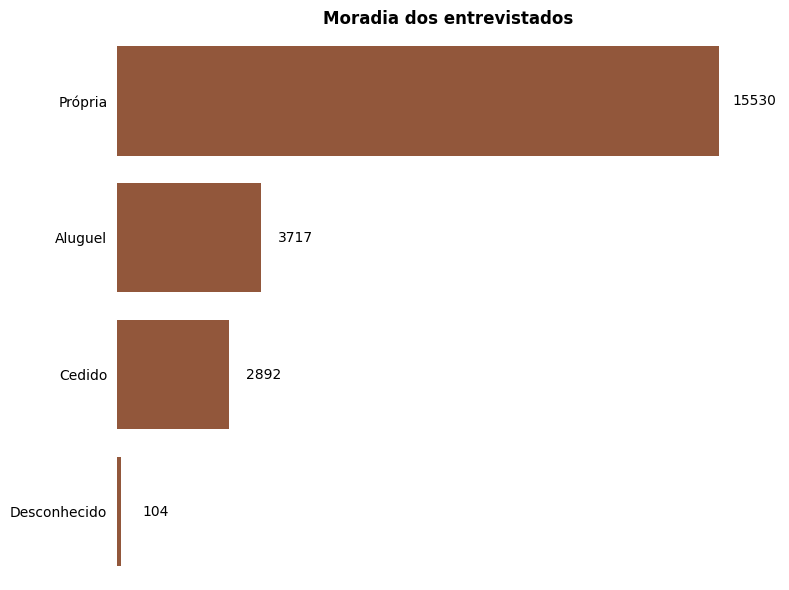

In [38]:
# Distribuição por moradia
moradia = df_filtrado['moradia'].value_counts()
# ordenando os valores em ordem decrescente
moradia.sort_values(ascending=False,inplace = True)

# definindo o tamanho da figura
plt.figure(figsize=(8,6))
# criando o grafico de moradia
ax = sns.barplot(x = moradia.values,y = moradia.index, color = 'sienna')

# criando rotulo de dados no grafico 
for p in ax.patches:
    width = p.get_width()
    ax.annotate(f'{width:.0f}',
                 (p.get_x() + width, p.get_y() + p.get_height() / 2),
                 ha='center', va='center', xytext=(25, 0),
                 textcoords='offset points')

# adicionando o titulo no grafico 
grafico_horizontal(ax,moradia,'Moradia dos entrevistados')

### Características econômicas da Sociedade

/var/folders/rf/8wnxmp196n904zdcm654qfbc0000gn/T/ipykernel_8082/3961613097.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtrado['faixa_etaria'] = pd.cut(


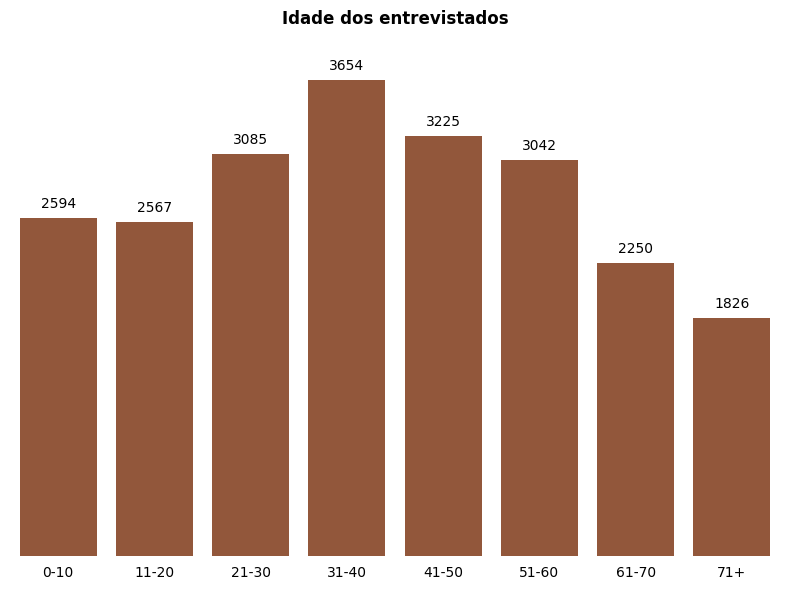

In [39]:
# Define os intervalos (bins) e os rótulos (labels)
bins = [0, 10, 20, 30, 40, 50, 60, 70, 120]
labels = ['0-10', '11-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71+']


# Criando uma nova coluna com a faixa etária
df_filtrado['faixa_etaria'] = pd.cut(
    df_filtrado['idade'],
    bins=bins,
    labels=labels,
    right=True,           # inclui o limite superior (ex: 10 entra em 0–10)
    include_lowest=True   # inclui o limite inferior (ex: 0 entra em 0–10)
)

# Distribuição por idade
idade = df_filtrado['faixa_etaria'].value_counts()
# ordenando os valores em ordem decrescente
idade.sort_values(ascending=False,inplace = True)

# definindo o tamanho da figura
plt.figure(figsize=(8,6))
# criando o grafico de quantidade de vinhos produzida
ax = sns.barplot(x = idade.index,y = idade.values, color = 'sienna')

# criando rotulo de dados no grafico 
for p in ax.patches:
    ax.annotate(f'{p.get_height():.0f}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10),
                textcoords='offset points')

# adicionando o titulo no grafico 
grafico_vertical(ax,idade,'Idade dos entrevistados')

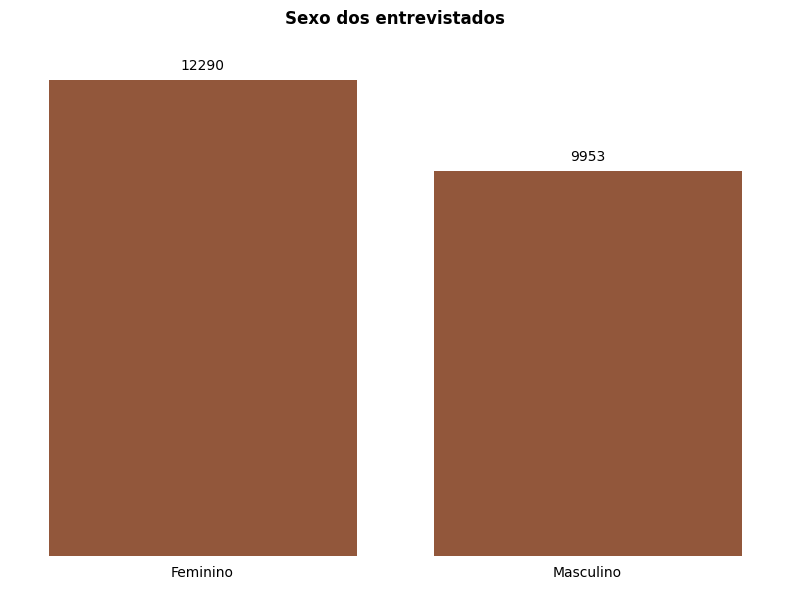

In [40]:
# Distribuição por sexo
sexo = df_filtrado['sexo'].value_counts()
# ordenando os valores em ordem decrescente
sexo.sort_values(ascending=False,inplace = True)

# definindo o tamanho da figura
plt.figure(figsize=(8,6))
# criando o grafico de quantsexo de vinhos produzida
ax = sns.barplot(x = sexo.index,y = sexo.values, color = 'sienna')

# criando rotulo de dados no grafico 
for p in ax.patches:
    ax.annotate(f'{p.get_height():.0f}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10),
                textcoords='offset points')

# adicionando o titulo no grafico 
grafico_vertical(ax,sexo,'Sexo dos entrevistados')

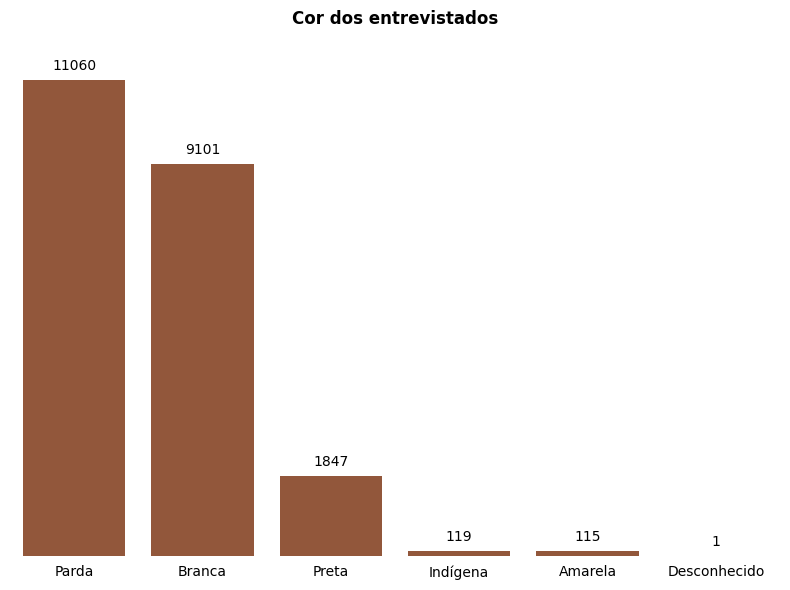

In [41]:
# Distribuição por cor
cor = df_filtrado['cor'].value_counts()
# ordenando os valores em ordem decrescente
cor.sort_values(ascending=False,inplace = True)

# definindo o tamanho da figura
plt.figure(figsize=(8,6))
# criando o grafico de quantcor de vinhos produzida
ax = sns.barplot(x = cor.index,y = cor.values, color = 'sienna')

# criando rotulo de dados no grafico 
for p in ax.patches:
    ax.annotate(f'{p.get_height():.0f}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10),
                textcoords='offset points')

# adicionando o titulo no grafico 
grafico_vertical(ax,cor,'Cor dos entrevistados')

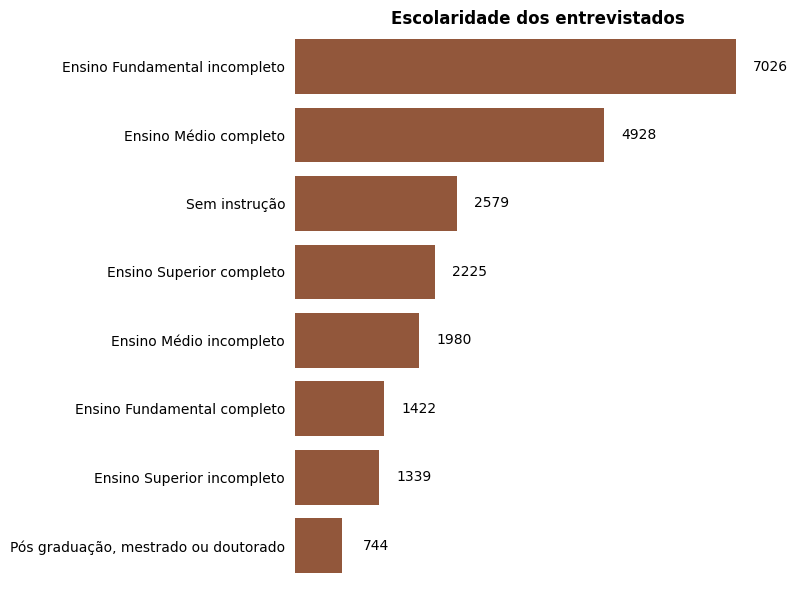

In [42]:
# Distribuição por escolaridade
escolaridade = df_filtrado['escolaridade'].value_counts()
# ordenando os valores em ordem decrescente
escolaridade.sort_values(ascending=False,inplace = True)

# definindo o tamanho da figura
plt.figure(figsize=(8,6))
# criando o grafico de quantescolaridade de vinhos produzida
ax = sns.barplot(x = escolaridade.values,y = escolaridade.index, color = 'sienna')

# criando rotulo de dados no grafico 
for p in ax.patches:
    width = p.get_width()
    ax.annotate(f'{width:.0f}',
                 (p.get_x() + width, p.get_y() + p.get_height() / 2),
                 ha='center', va='center', xytext=(25, 0),
                 textcoords='offset points')

# adicionando o titulo no grafico 
grafico_horizontal(ax,escolaridade,'Escolaridade dos entrevistados')